## Imports

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
from progress.bar import Bar

## Load the data

In [26]:
data_path = "../../dataset/data/"
HM_names = ["H3K27me3", "H3K26me3", "H3K4me1", "H3K4me3", "H3K9me3"]
columns_names = ["geneID", "binID", "HM1", "HM2", "HM3", "HM4", "HM5", "label"]

In [27]:
def load_datasets(folder_name):    
    # ? test.csv
    test_df = pd.read_csv(f"{data_path}{folder_name}/classification/test.csv", header=None, names=columns_names,)
    # ? train.csv
    train_df = pd.read_csv(f"{data_path}{folder_name}/classification/train.csv", header=None, names=columns_names,)
    # ? valid.csv
    valid_df = pd.read_csv(f"{data_path}{folder_name}/classification/valid.csv", header=None, names=columns_names,)
    return (train_df, valid_df, test_df)

In [28]:
def create_dataset(df, maxElements):
    data = []
    labels = []
    genes_inserted = {}

    range_ = range(int(len(df) / 100))
    if maxElements:
        range_ = range_[:maxElements]
    #bar = Bar("\t- creating datasets", max=len(range_))
    for i in range_:  # todo: remove this limit to consider the full dataset
        geneID = df.iloc[i * 100]["geneID"]
        if genes_inserted.get(geneID) is None:
            genes_inserted[geneID] = True

            df_gene = df.loc[df["geneID"] == geneID]

            labels.append(df_gene.iloc[0]["label"])  # ? saving the label once and for all the gene
            # ? extract the whole list of values for the different HMs as a matrix
            # ! I had to put [:100] to limit the errors on the input data (e.i. some genes where duplicates)
            gene_data = [
                list(df_gene["HM1"])[:100],
                list(df_gene["HM2"])[:100],
                list(df_gene["HM3"])[:100],
                list(df_gene["HM4"])[:100],
                list(df_gene["HM5"])[:100],
            ]
            data.append(gene_data)
        #bar.next()
    #bar.finish()
    return (data, labels)


In [29]:
def to_numpy(data, labels):
    #bar = Bar("\t- converting to numpy format", max=len(data))
    numpy_data = np.array([])
    for gene in data:
        numpy_gene = np.array([])
        for bins in gene:
            numpy_gene = np.append(numpy_gene, np.array(bins))
        numpy_data = np.append(numpy_data, numpy_gene)
        #bar.next()
    #bar.finish()
    numpy_data = numpy_data.reshape(len(data), 5, 100, 1)
    numpy_labels = np.array(labels)
    return numpy_data, numpy_labels

In [30]:
def normalize(data):    
    return data

In [31]:
def load(maxFolders=None, maxElements=None):

    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    if maxFolders:
        dirs = dirs[:maxFolders]
    #bar = Bar("loading", max=len(dirs))
    for folder in dirs:
        (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_folder(
            folder, maxElements
        )

        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

        #bar.next()
    #bar.finish()

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels),
    )

In [32]:
def load_folder(folder_name, maxElements=None):
    print(folder_name)
    # loading the datasets
    print("\tloading")
    train_df, valid_df, test_df = load_datasets(folder_name)

    # create the datasets with the correct format
    print("\tcreating datasets")
    train_data, train_labels = create_dataset(train_df, maxElements)
    valid_data, valid_labels = create_dataset(valid_df, maxElements)
    test_data, test_labels = create_dataset(test_df, maxElements)

    # normalize data
    print("\tnormalizing")
    train_data = normalize(train_data)
    valid_data = normalize(valid_data)
    test_data = normalize(test_data)

    # numpy arrays
    print("\tto numpy")
    train_data, train_labels = to_numpy(train_data, train_labels)
    valid_data, valid_labels = to_numpy(valid_data, valid_labels)
    test_data, test_labels = to_numpy(test_data, test_labels)

    # return tris of tuples (data,labels)
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))


## Create the model

In [38]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load(10)

E003
	loading
	creating datasets
	normalizing
	to numpy
E004
	loading
	creating datasets
	normalizing
	to numpy
E005
	loading
	creating datasets
	normalizing
	to numpy
E006
	loading
	creating datasets
	normalizing
	to numpy
E007
	loading
	creating datasets
	normalizing
	to numpy
E011
	loading
	creating datasets
	normalizing
	to numpy
E012
	loading
	creating datasets
	normalizing
	to numpy
E013
	loading
	creating datasets
	normalizing
	to numpy
E016
	loading
	creating datasets
	normalizing
	to numpy
E024
	loading
	creating datasets
	normalizing
	to numpy


### Model 1
Basic model

In [47]:
model = models.Sequential()

model.add(layers.Conv2D(32, (2, 2), activation="relu", input_shape=(5, 100, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1))

### Model 2
More complex model with different layers

In [51]:
model = models.Sequential()

model.add(layers.ZeroPadding2D((2, 2), input_shape=(5, 100, 1)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))

In [52]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 9, 104, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 102, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 51, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 50, 128)        32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 50, 128)        512       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 25, 128)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)             

## Train & evaluate the model

In [53]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

history = model.fit(train_data, train_labels, epochs=5, validation_data=(valid_data, valid_labels))

Epoch 1/5
2063/2063 [==============================] - 65s 31ms/step - loss: 0.6492 - accuracy: 0.6318 - val_loss: 0.5369 - val_accuracy: 0.6859
Epoch 2/5
2063/2063 [==============================] - 67s 32ms/step - loss: 0.5834 - accuracy: 0.6607 - val_loss: 0.5286 - val_accuracy: 0.7015
Epoch 3/5
2063/2063 [==============================] - 74s 36ms/step - loss: 0.5793 - accuracy: 0.6630 - val_loss: 0.5313 - val_accuracy: 0.7033
Epoch 4/5
2063/2063 [==============================] - 79s 38ms/step - loss: 0.5725 - accuracy: 0.6677 - val_loss: 0.5325 - val_accuracy: 0.7021
Epoch 5/5
2063/2063 [==============================] - 76s 37ms/step - loss: 0.5674 - accuracy: 0.6722 - val_loss: 0.5287 - val_accuracy: 0.7048


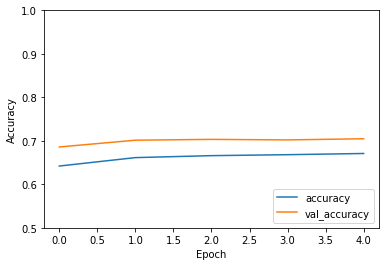

2062/2062 - 11s - loss: 0.4222 - accuracy: 0.7874
0.7873882055282593


In [55]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

print(test_acc)